In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import gzip
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from functools import partial

import torch
from torch import nn
from torch import tensor
import torch.nn.functional as F

from fastai import datasets
from exp.utils import accuracy
from exp.learner import Learner
from exp.hooks import Hook, append_stats
from exp.optimizer import SgdOptimizer
from exp.callbacks import AvgStatsCallback, ProgressCallback, Recorder, CudaCallback
from exp.data import normalize_to, Dataset, DataBunch, get_dls
from exp.module import Lambda

## Get Data

In [3]:
def get_data(mb=True):
    if mb:
        fname = "/home/ricky/Desktop/repos/fastai_course/course_2/data/mnist/mnist.pkl.gz"
    else:
        fname = "/Users/ricardofernandez/.fastai/data/mnist/mnist.pkl.gz"
    
    path = datasets.download_data(
        url="http://deeplearning.net/data/mnist/mnist.pkl",
        fname=fname, ext=".gz")
    
    with gzip.open(path, "rb") as f:
        ((x_train, y_train), (x_test, y_test), _) = pickle.load(f, encoding="latin-1")
        
    return map(tensor, (x_train, y_train, x_test, y_test))

x_train, y_train, x_valid, y_valid = get_data()

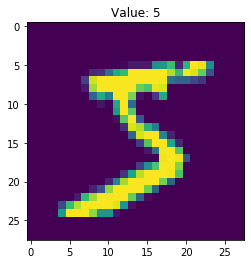

In [4]:
plt.imshow(x_train[0].view(28,28))
plt.title(f"Value: {y_train[0]}");

In [5]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [6]:
batch_size = 512
num_classes = y_train.max().item() + 1
data = DataBunch(*get_dls(train_ds, valid_ds, batch_size), num_classes)

In [7]:
data.train_ds is train_ds

True

In [8]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([512, 784]), torch.Size([512]))

## Model 

In [9]:
def flatten(x):
    return x.view(x.shape[0], -1)

def mnist_resize(x):
    return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1,  8, 5, padding=2, stride=2), nn.ReLU(),
        nn.Conv2d( 8, 16, 3, padding=1, stride=2), nn.ReLU(),
        nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(),
        nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
        )

In [11]:
model = get_cnn_model(data)

In [12]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
list(model.children())

[Lambda(),
 Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
 ReLU(),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 ReLU(),
 AdaptiveAvgPool2d(output_size=1),
 Lambda(),
 Linear(in_features=32, out_features=10, bias=True)]

In [14]:
list(model[:4].children())

[Lambda(),
 Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
 ReLU(),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))]

In [15]:
model(x).shape

torch.Size([512, 10])

In [16]:
hooks = [Hook(l, append_stats) for l in model[1:4].children()]

## Loss Function

In [17]:
loss = F.cross_entropy
loss(model(x), y)

tensor(2.3029, grad_fn=<NllLossBackward>)

## Optimizer

In [18]:
sgd = SgdOptimizer(model.parameters())
sgd

torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])

## Callbacks 

In [19]:
callbacks = [ProgressCallback, partial(AvgStatsCallback, accuracy), CudaCallback]

## Learner 

In [20]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [21]:
from torch.optim import SGD

In [22]:
learn = Learner(model, data, loss, lr=0.4, cb_funcs=callbacks, opt_func=SGD)

In [23]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.096906,0.264500,1.084192,0.606800,00:00


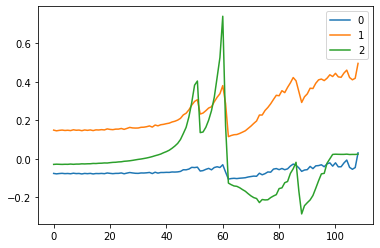

In [24]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4))

In [27]:
o = SGD(model.parameters(), lr=0.5)

In [29]:
for k in o.param_groups:
    pass

In [30]:
k

{'params': [Parameter containing:
  tensor([[[[ 0.1214,  0.2004, -0.0281,  0.2291,  0.1292],
            [ 0.1693,  0.3416,  0.3914,  0.1817,  0.1045],
            [ 0.1578,  0.3457,  0.3104,  0.3993,  0.3667],
            [ 0.3084,  0.2860,  0.1680,  0.3614,  0.1265],
            [ 0.2504,  0.0178,  0.3041,  0.1252,  0.2295]]],
  
  
          [[[ 0.0944, -0.1441,  0.2364,  0.0889,  0.1489],
            [ 0.0131, -0.1006, -0.1009,  0.1062,  0.0875],
            [-0.1585,  0.2659,  0.2634,  0.0498,  0.0604],
            [-0.0802,  0.1361,  0.2058,  0.1262,  0.1150],
            [ 0.0381,  0.1803, -0.0988,  0.1780, -0.1248]]],
  
  
          [[[-0.0267,  0.0116,  0.0045, -0.0904,  0.1056],
            [-0.0637, -0.1258, -0.0781,  0.1452, -0.0922],
            [ 0.1067, -0.0119,  0.0684, -0.0224, -0.0962],
            [-0.1498,  0.1743, -0.1739, -0.0207, -0.0126],
            [-0.1157, -0.0922,  0.0419,  0.0233,  0.1269]]],
  
  
          [[[-0.1320,  0.0447,  0.1463,  0.0619, -0.0845]

In [31]:
k.keys()

dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov'])